# L12d: Structure and Training of Recurrent Neural Networks
In this lab, we'll construct and train an [Elman recurrent network network](https://en.wikipedia.org/wiki/Elman_network) for the prediction of a temperature time series using [the `Flux.jl` machine learning package](https://github.com/FluxML/Flux.jl).

* _Objective_: We'll train a recurrent neural network (RNN) to _predict_ the high temperature for day $i$ given the low temperature for day $i$. This is an example of a `many-to-many` (or a sequence-to-sequence) prediction problem, i.e., we provide a sequence of low-temperature values and ask the network to predict the corresponding sequence of high-temperature values. The Elman network is a simple RNN used for this type of problem.
* _Implementation_: Toward our objective, we'll use [the `Flux.jl` package](https://github.com/FluxML/Flux.jl) to build, train, and test our recurrent weather prediction model. The [`Flux.jl` package](ttps://github.com/FluxML/Flux.jl) is a Julia library for machine learning designed to be easy to use and flexible. However, there are two excellent libraries for ANNs in Python (sort of), namely the [PyTorch library](https://pytorch.org/) from the [AI group at META](https://ai.meta.com/meta-ai/) and the [TensorFlow library](https://www.tensorflow.org/) developed by [Google](https://research.google/). 


## Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (10 min)__: Let's take 5 minutes to load and analyze a weather dataset downloaded from [the National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00304174/detail). Once we load the data, we'll do some data wrangling (scaling).
* __Task 2: Setup the model structure and training (15 min)__: In this task, we'll construct and train the RNN model, i.e., we'll learn the model parameters, using [the gradient descent with momentum algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) to minimize [the mean-squared error (mse) loss function](https://fluxml.ai/Flux.jl/stable/reference/models/losses/#Flux.Losses.mse). 
* __Task 3: Play around with the model structure and parameters (20 min)__: In this task, we'll change the model structure, e.g., how many hidden states we have, and include other layers. We'll also change the learning rate and other hyperparameters and look at their effect on the model performance. We'll also look at the effect of changing the number of training epochs and the batch size.

Let's get started!
___

## Task 1: Setup, Data and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

### Weather Dataset
We'll use a weather dataset for this lecture. The dataset contains daily weather data for Cornell from January 2025 until last week, including low and high temperatures for each day. The data is available in the repository's `data` folder. 
* _Data_: The data is in CSV format; we load it using [the `CSV.jl` package](https://github.com/JuliaData/CSV.jl) and store the data [using the `DataFrame` type exported from the `DataFrames.jl` package](https://dataframes.juliadata.org/stable/). 

We store _scaled_ `TMIN` and `TMAX` values in the `X̂::Array{Float32,2}` variable, and the `rawdata::DataFrame` variable contains the entire dataset. Each row of `X̂` is a day, while the first column is the _low_ temperature, and the second column is the `high` temperature for a particular day.

#### Scaling
We scale the $N$ temperature values in the weather dataset such that $\hat{T}\in\left[0,1\right]$ using the scaling rule:
$$
\begin{align*}
\hat{T}_{i} = \frac{T_{i} - T_{min}}{T_{max} - T_{min}}\quad{i = 1,2,\dots,N}
\end{align*}
$$
where $\hat{T}_{i}$ denotes the scaled temperature for day $i$, and $T_{max}$ denotes the maximum temperature, and $T_{min}$ denotes the minimum temperature in the temperature series for either the low or high temperatures.
* __Discussion__: Why do we need to do this scaling, and particularly, why do we need the data to be $[0,1]$?

In [5]:
X̂, rawdata = let

    # raw data -
    rawdata = CSV.read(joinpath(_PATH_TO_DATA, "Temp-ITH-YTD-NOAA-2025.csv"), DataFrame); # load the data from a CSV file into a DataFrame
    temparray = @select rawdata :TMIN :TMAX; # Wow! Grab the Tmax and Tmin using the @select macro from the DataFramesMeta.jl package.
    X = temparray .|> Float32 |> Matrix # convert to Float32

    # scale the data -
    number_of_rows = size(X, 1); # get the number of rows
    number_of_columns = size(X, 2); # get the number of columns
    X̂ = zeros(Float32, number_of_rows, number_of_columns); # create a new matrix of zeros with the same size as X
    for i in 1:number_of_columns
        X̂[:, i] = (X[:, i] .- minimum(X[:, i])) ./ (maximum(X[:, i]) - minimum(X[:, i])); # scale the data to the range [0, 1]
    end

    # return -
    X̂,rawdata;
end;

In [6]:
size(X̂,1) |> x-> println("We have $(x) days of weather data")  # get the number of rows in the scaled data

We have 91 days of weather data


__Constants__: Let's set some constants that we'll use throughout the lecture. Please take a look at the comment next to each constant for its purpose, permissible values, default value, etc.

In [108]:
number_of_inputs = 30; # dimension of the input
number_of_outputs = 30; # dimension of the output
number_of_hidden_states = 100; # number of hidden neurons
σ₁ = NNlib.tanh_fast; # activation function
σ₂ = NNlib.tanh_fast; # activation function
number_of_epochs = 100; # how many epochs do we want to train for?

__Training data__: In the code block below, we specify the training data for our RNN. To make our life easier, we grab the first `number_of_inputs::Int` days of data to train the model.

In [110]:
xₒ = ones(Float32, (number_of_inputs, 1)).*X̂[1:number_of_inputs,1]; # create a random input vector
yₒ = ones(Float32, (number_of_outputs, 1)).*X̂[1:number_of_outputs,2]; # create a random output vector

## Task 2: Construct and Train an Elman Network
The Elman network is a simple RNN type consisting of an input, hidden, and output layer. The hidden layer has recurrent connections that allow it to maintain a _hidden state_ (memory) over time [Elman, J. L. (1990). Finding structure in time. Cognitive Science, 14(2), 179-211.](https://onlinelibrary.wiley.com/doi/10.1207/s15516709cog1402_1)

### Background
Let $\mathbf{x}_{t}\in\mathbb{R}^{d_{in}}$ denote the $d_{in}$-dimensional input vector, and $\mathbf{h}_t\in\mathbb{R}^{h}$ denote the $h$-dimensional hidden state vector at time $t$. The Elman network has a recurrent connection from the hidden layer to itself, which allows it to maintain a memory of past inputs. We denote the $d_{out}$-dimensional output vector at time $t$ as $\mathbf{y}_t\in\mathbb{R}^{d_{out}}$. An Elman network can be represented:
$$
\begin{align*}
\mathbf{h}_t &= \sigma_{h}(\mathbf{U}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t + \mathbf{b}_h) \\
\mathbf{y}_t &= \sigma_{y}(\mathbf{W}_y \mathbf{h}_t + \mathbf{b}_y)
\end{align*}
$$
where the parameters are:
* _Network weights_: the term $\mathbf{U}_h\in\mathbb{R}^{h\times{h}}$ is the weight matrix for the hidden state, $\mathbf{W}_x\in\mathbb{R}^{h\times{d_{in}}}$ is the weight matrix for the input, and $\mathbf{W}_y\in\mathbb{R}^{d_{out}\times{h}}$ is the weight matrix for the output
* _Network bias_: the $\mathbf{b}_h\in\mathbb{R}^{h}$ terms denote the bias vector for the hidden state, and $\mathbf{b}_y\in\mathbb{R}^{d_{out}}$ is the bias vector for the output.
* _Activation function_: the $\sigma_{h}$ function is a _hidden layer activation function_, such as the sigmoid or hyperbolic tangent (tanh) function, which introduces non-linearity into the RNN. The activation function $\sigma_{y}$ is an _output activation function_ that can be a softmax function for classification tasks or a linear function for regression tasks.

How many parameters are there in the Elman network? The number of parameters in an Elman RNN can be calculated as follows:
* _Hidden state_: The number of parameters for the hidden state is $h^2 + d_{in}h + h = h(h + d_{in} + 1)$
* _Output_: The number of parameters for the output is $d_{out}h + d_{out} = d_{out}(h + 1)$
* _Total_: The total number of parameters in the Elman RNN is $h(h + d_{in} + 1) + d_{out}(h + 1)$

Let's build a simple Elman RNN [using the `Flux.jl` package](https://fluxml.ai/Flux.jl/stable/) to understand better how it works.

In [112]:
Flux.@layer MyFluxElmanRecurrentNeuralNetworkModel trainable=(hidden, output); # create a "namespaced" of sorts
MyElmanRNNModel() = MyFluxElmanRecurrentNeuralNetworkModel( # a strange type of constructor
    Flux.Chain(
        hidden = Flux.RNN(number_of_inputs => number_of_hidden_states, σ₁),  # hidden layer
        output = Flux.Dense(number_of_hidden_states => number_of_outputs, σ₂), # output layer
        # finish = NNlib.sigmoid # final activation function # TODO: uncomment me to run the output through another function
    )
);
elmanmodel = MyElmanRNNModel().chain; # Hmmm. elmanmodel is callable? (Yes, because of a cool Julia syntax quirk)

__Check__: Is the number of parameters in the Elman network correct? We have an analytical estimate of the number of parameters that we expect for a vanilla Elman RNN; let's verify!

In [114]:
let

    # analytical estimate -
    h = number_of_hidden_states; # number of hidden neurons
    din = number_of_inputs; # number of inputs
    dout = number_of_outputs; # number of outputs
    analytical_estimate = h*(h+din+1) + dout*(h+1)# analytical estimate of the number of parameters

    # compute the number of parameters from the model -
    p = Flux.trainable(elmanmodel); # get the parameters of the model
    
    # RNN (hidden) layer -
    Wᵢ = p.layers.hidden.cell.Wi; # input weights
    Wₕ = p.layers.hidden.cell.Wh; # hidden weights
    bᵢ = p.layers.hidden.cell.bias; # input biases
    hidden_layer_parameter_count = size(Wᵢ, 1) * size(Wᵢ, 2) + size(Wₕ, 1) * size(Wₕ, 2) + size(bᵢ, 1); # number of parameters in the hidden layer

    # Dense layer (output) -
    W = p.layers.output.weight; # output weights
    b = p.layers.output.bias; # output biases
    output_layer_parameter_count = size(W, 1) * size(W, 2) + size(b, 1); # number of parameters in the output layer
    total_parameter_count = hidden_layer_parameter_count + output_layer_parameter_count; # total number of parameters

    # output -
    println("Analytical estimate: $(analytical_estimate). Model count: $(total_parameter_count)"); # print the analytical estimate
end

Analytical estimate: 16130. Model count: 16130


### Training performance
Next, let's set up the model training. One of the shortcomings of [the `Flux.jl` package](https://fluxml.ai/Flux.jl/stable/) is the generally opaque nature of model training. It's a headache, but I've figured it out (for the most part). On the other hand, it does handle the model unrolling step for us, so the training works like a feedforward model.
* _Which optimizer_? The [`Flux.jl` library supports _many_ optimizers](https://fluxml.ai/Flux.jl/stable/reference/training/optimisers/#Optimisers-Reference) which are all some version of gradient descent. We'll use [Gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) where the `λ` parameter denotes the `learning rate` and `β` denotes the momentum parameter. We save information about the optimizer in the `opt_state` variable, which will eventually get passed to the training method.

In [116]:
λ = 0.25; # TODO: update the learning rate (good: 0.25)
β = 0.10; # TODO: update the momentum parameter (good: 0.10)
opt_state = Flux.setup(Momentum(λ, β), elmanmodel); # opt_state has all the details of the optimizer

__Training loop__. `Unhide` the code block below to see the training loop for our Elman RNN. In the training loop, we process the training data for `number_of_epochs::Int` epochs (each epoch is one complete pass through all the training data). The implementation below uses [a few interesting `Flux.jl` specific features](https://github.com/FluxML/Flux.jl). 
* _Automatic gradient?_: The [`Flux.jl` package](https://fluxml.ai/Flux.jl/stable/) has [the `gradient(...)` method](https://fluxml.ai/Flux.jl/stable/guide/models/basics/#man-taking-gradients) which [uses automatic differentiation](https://arxiv.org/abs/1502.05767) to compute _exact_ gradients numerically. This is a super interesting feature that removes much of the headache associated with computing the gradient of neural networks.
* _Update!?_ The [`update!(...)` method](https://fluxml.ai/Flux.jl/stable/reference/training/reference/#Optimisers.update!) is a [mutating method](https://docs.julialang.org/en/v1/manual/functions/#man-functions), i.e., changes made in the method are visible in the calling scope. In this case, the [`update!(...)` method](https://fluxml.ai/Flux.jl/stable/reference/training/reference/#Optimisers.update!) using the gradient and the optimizer to update the model parameters stored in the model instance. It also updates the `opt_state` data, although what it is doing is not clear.

In [118]:
trainedmodel = let
   
    model = elmanmodel; # this is the model we want to train (with default parameters initially)
    tree = opt_state; # details of the optimizer
    for i ∈ 1:number_of_epochs
        
        g = gradient(m -> Flux.mse(m(xₒ), yₒ), model); # Hmmm. This uses automatic differentiation, cool!
        (newtree, newmodel) = Flux.update!(tree, model, g[1]) # run the model to convergence(?) - not sure. Docs are bad. Come on Flux.jl!!
        
        model = newmodel; # reset the model to the new *updated* instance
        tree = newtree; # reset the opt tree to the new *updated* instance (not sure what is going on here, Docs bad! Get it together Flux.jl!)
    end
    model # return the updated model
end

Chain(
  hidden = RNN(30 => 100, tanh_fast),   # 13_100 parameters
  output = Dense(100 => 30, tanh_fast),  # 3_030 parameters
)                   # Total: 5 arrays, 16_130 parameters, 63.266 KiB.

#### Visualize the training performance
Let's plot the performance of the _trained_ model. However, we'll start by computing the mean-squared error (MSE) loss function on the _training_ set. The MSE loss function is defined as:
$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(\mathbf{y}_i - \hat{\mathbf{y}}_i)^2
$$
where $\mathbf{y}_i$ is the true output, $\hat{\mathbf{y}}_i$ is the predicted output, and $n$ is the number of samples in the training set. The MSE loss function measures the average squared difference between the true and predicted outputs.

In [120]:
let
    msevalue = Flux.mse(trainedmodel(xₒ), yₒ) # calculate the mean squared error of the trained model on the *training* data
    println("MSE training: ", msevalue) # print the mean squared error
end

MSE training: 3.4589258e-14


`Unhide` the code block below to see how we plotted the _actual_ scaled maximum temperature and the _predicted_ maximum temperate for `number_of_inputs::Int` days of training data.

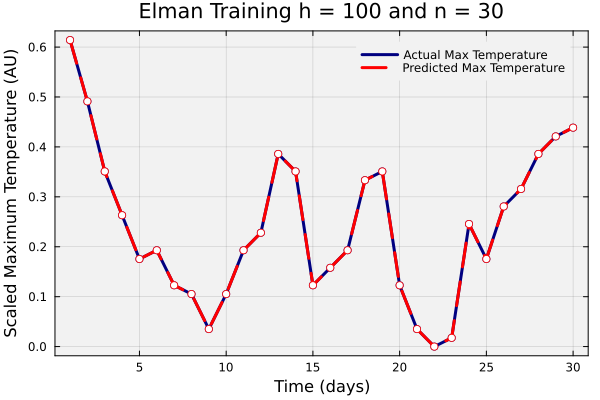

In [122]:
let
    # initialize -
    t = range(1,step=1,stop=number_of_inputs) |> collect; # create a range of numbers from 1 to number_of_training_samples

    # plots -
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    plot!(t, yₒ, label="Actual Max Temperature", lw=3, color=:navy);
    scatter!(t,yₒ, msc=:navy, c=:white, label="")
    plot!(t, trainedmodel(xₒ), label="Predicted Max Temperature", lw=3, color=:red, ls=:dash);
    scatter!(t,trainedmodel(xₒ), c=:white, msc=:red, label="")
    xlabel!("Time (days)");
    ylabel!("Scaled Maximum Temperature (AU)");
    title!("Elman Training h = $(number_of_hidden_states) and n = $(number_of_inputs)", fontsize=12);
end

#### Discussion
* Get with your neighbor and discuss the performance of the model. How well does the model perform with the default values for the various hyperparameters and the default model structure (number of hidden states, etc.)? There is at least one critical issue with the model performance. What is it?

### Test performance
Now that we have trained the model, we can test it on the test set. The test set is a separate dataset that was not used during training. We will use the same loss function as before to compute the loss of the training model on the test set.

Let's start by generating the test data set. In this case, we will slide the input time window and grab another `number_of_inputs::Int` days of data (beginning one day after the end of the training data). We store the test input in the `x₁::Matrix{Float32}` variable and the test output in the `y₁::Matrix{Float32}` variable. 

In [125]:
x₁,y₁ = let

    # initialize -
    prediction_index = range(number_of_inputs+1,step=1,stop=2*number_of_inputs) |> collect; # create a range of numbers from number_of_training_samples+1 to number_of_training_samples+number_of_test_samples
    x₁ = ones(Float32, (number_of_inputs, 1)).*X̂[prediction_index,1]; # test input vector scaled Tmin
    y₁ = ones(Float32, (number_of_outputs, 1)).*X̂[prediction_index,2]; # test output vector scaled Tmax

    # return -
    x₁,y₁;
end;

Next, compute the mean-squared error (MSE) loss function on the _test_ data set. The MSE loss function is defined as:
$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(\mathbf{y}_i - \hat{\mathbf{y}}_i)^2
$$
where $\mathbf{y}_i$ is the true output, $\hat{\mathbf{y}}_i$ is the predicted output, and $n$ is the number of samples in the test set. 

In [127]:
let
    msevalue = Flux.mse(trainedmodel(x₁), y₁) # calculate the mean squared error of the trained model on the *training* data
    println("MSE test: ", msevalue) # print the mean squared error
end

MSE test: 0.055512197


`Unhide` the code block below to see how we plotted the _actual_ scaled maximum temperature and the _predicted_ maximum temperate for `number_of_inputs::Int` days of test data.

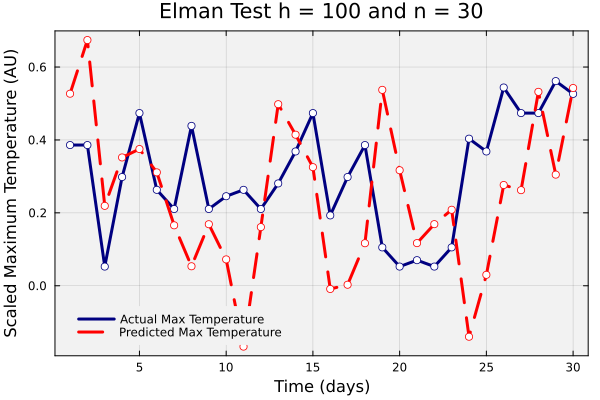

In [129]:
let 
    
    # initialize -
    t = range(1,step=1,stop=number_of_inputs) |> collect; # create a range of numbers from 1 to number_of_training_samples

    # plots -
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(t, y₁, label="Actual Max Temperature", lw=3, color=:navy);
    scatter!(t,y₁, msc=:navy, c=:white, label="")
    plot!(t, trainedmodel(x₁), label="Predicted Max Temperature", lw=3, color=:red, ls = :dash);
    scatter!(t,trainedmodel(x₁), c=:white, msc=:red, label="")
    xlabel!("Time (days)");
    ylabel!("Scaled Maximum Temperature (AU)");
    title!("Elman Test h = $(number_of_hidden_states) and n = $(number_of_inputs)", fontsize=12);
end

#### Discussion
* Get with your neighbor and discuss the model's performance on the test data. How well does the model perform with the default values for the various hyperparameters and the default model structure (number of hidden states, etc.)? There is at least one critical issue with the model performance. What is it?

## Task 3: Play around with the model structure and parameters
In this task, we'll change the model structure, e.g., how many hidden states we have, include other layers, change the learning rate and other hyperparameters, and look at the effect on the model performance. We'll also look at the impact of changing the number of training epochs.

What happens if we:
* All else held constant, change the learning rate and momentum parameters? Set $\alpha=0.25$ and $\beta=0.10$.
* Change the number of hidden states. Using the new learning rate and momentum parameters, set the number of hidden states to `number_of_hidden_states = 100`.
* Change the number of training epochs Using the new learning rate momentum parameters and hidden states. Change the number of epochs to `number_of_epochs = 100`.
* Using the new learning rate momentum parameters and hidden states, change the output activation function to $\texttt{relu}$? (or add some additional layers?)